In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
import time 
# from tensorflow.keras.applications import *
# from matplotlib import plotly as plt
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import pickle
from sklearn.decomposition import PCA

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]


(30000, 56, 28)
(30000, 2)


2022-07-01 17:28:37.458793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-01 17:28:38.018100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9651 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:d8:00.0, compute capability: 7.5


(5000, 56, 28, 1)
(5000, 2)
(56, 28, 1)


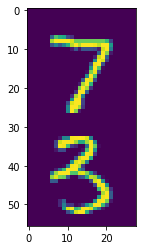

tf.Tensor(
[[7. 3.]
 [2. 9.]
 [1. 9.]
 ...
 [2. 4.]
 [4. 5.]
 [0. 6.]], shape=(5000, 2), dtype=float32)


In [3]:
batch_size = 32
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

N = x_train.shape[0] // 2
x_train = np.concatenate((x_train[:N], x_train[N:]), axis=1)
y_train = np.stack((y_train[:N], y_train[N:]), axis=1)
# y_train = tf.ones(y_train.shape)
N = x_test.shape[0] // 2

x_test = np.concatenate((x_test[:N], x_test[N:]), axis=1)
y_test = np.stack((y_test[:N], y_test[N:]), axis=1)
# y_test = tf.ones(y_test.shape)
print(x_train.shape)
print(y_train.shape)



input_shape = x_train[0].shape

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

x_test = tf.expand_dims(x_test, -1)
x_train = tf.expand_dims(x_train, -1)
print(x_test.shape)
print(y_test.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)

input_shape = x_test[0].shape
num_classes = 10
print(input_shape)

plt.figure()
plt.imshow(x_test[0, :, :, 0]) 
plt.show()
print(y_test)



In [68]:
(x_same, _), (_, _) = tf.keras.datasets.mnist.load_data()

x_same = np.concatenate((x_same[:N], x_same[:N]), axis=1)
print(x_same.shape)

(5000, 56, 28)


In [4]:
kernel_size = (3, 3 )

dilation_rate = 1

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.Conv2D(64, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(50, activation="relu"),
        layers.Dense(2*num_classes, activation=None),
    ]
)

model.summary()


optimizer = tf.keras.optimizers.Adam(0.001)

cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# loss_fn = cce_loss
def loss_fn(y, y_hat): 
#     print(y[:, 0], y_hat[:, :10])
    return cce_loss(y[:, 0], y_hat[:, :10]) + cce_loss(y[:, 1], y_hat[:, 10:])

#         cce_loss(y_batch_train[:, 0], logits[:, :10]) + cce_loss(y_batch_train[:, 0], logits[:, 10:])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 28, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 28, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 7, 32)        0         
 2D)                                                    

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=loss_fn
)

model.fit(
    train_dataset,
    epochs=6,
    validation_data=test_dataset,
)
# !mkdir -p saved_model

# model.save('saved_model/my_model')


Epoch 1/6


2022-07-01 17:28:40.087905: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2022-07-01 17:28:40.584566: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


938/938 [==============================] - 12s 10ms/step - loss: 1.6449 - val_loss: 0.4653
Epoch 2/6
938/938 [==============================] - 9s 10ms/step - loss: 0.3874 - val_loss: 0.3128
Epoch 3/6
938/938 [==============================] - 9s 10ms/step - loss: 0.2545 - val_loss: 0.2565
Epoch 4/6
938/938 [==============================] - 9s 10ms/step - loss: 0.1941 - val_loss: 0.2474
Epoch 5/6
938/938 [==============================] - 9s 10ms/step - loss: 0.1358 - val_loss: 0.1762
Epoch 6/6
938/938 [==============================] - 9s 10ms/step - loss: 0.1015 - val_loss: 0.1669


tf.Tensor([0. 6.], shape=(2,), dtype=float32)
conv2d
[0.2783005, 0.2390292, 0.19984548, 0.23694846, 0.19157255, 0.2781461, 0.2611245, 0.22263443, 0.15322213, 0.19050139, 0.23810366, 0.31842983, 0.19072947, 0.26445705, 0.25442845, 0.24294585, 0.30955833, 0.18076727, 0.13374275, 0.15273309]
conv2d_1
[0.38671806, 0.3359443, 0.2906912, 0.34173876, 0.27693892, 0.41067162, 0.3938992, 0.3169968, 0.23029867, 0.2857609, 0.34711394, 0.43941355, 0.28208533, 0.37397778, 0.35708928, 0.3624041, 0.4191304, 0.25078902, 0.18283159, 0.22217509]
conv2d_2
[0.63131684, 0.5678634, 0.49481058, 0.57321477, 0.47598004, 0.6477847, 0.6336502, 0.5210641, 0.37234372, 0.47385934, 0.5481988, 0.69180155, 0.44194022, 0.57914495, 0.5875131, 0.5754461, 0.65135145, 0.37899256, 0.2937635, 0.35332412]
max_pooling2d
[0.65158296, 0.58615094, 0.5139437, 0.5971681, 0.49422765, 0.67401266, 0.6590357, 0.53966516, 0.38594574, 0.4886877, 0.5743429, 0.7201766, 0.46039963, 0.61032104, 0.60951436, 0.5970819, 0.6810932, 0.3946125, 0.3

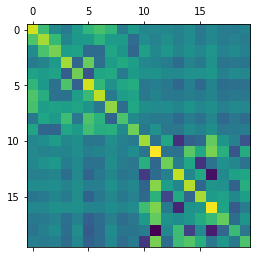

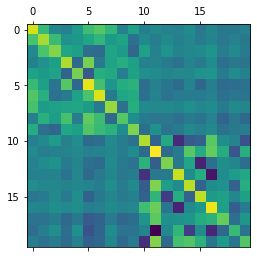

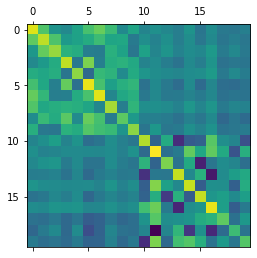

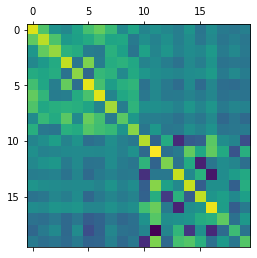

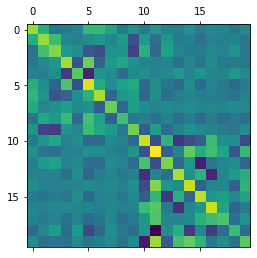

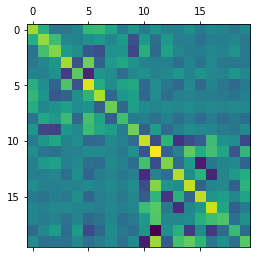

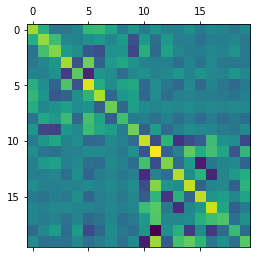

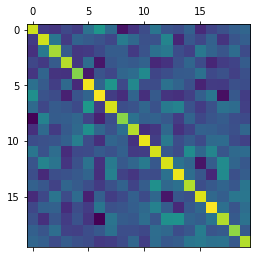

In [69]:

k=10
n = 10
x = x_same[k:k+n]
# y = y_test[k:k+n]

print(y_test[k])

for i, layer in enumerate(model.layers[:-1]): 
    print(layer.name)
    
    aux_model1 = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
    aux_model2 = tf.keras.Model(inputs=model.layers[i+1].input, outputs=model.output)
    jac = [] 
    for i in range(n):

        with tf.GradientTape() as t:
            hidden = aux_model1(x[i:i+1])

            hidden = tf.Variable(hidden)
            logits = aux_model2(hidden) 
            probs = tf.concat((tf.nn.softmax(logits[:, :10]), tf.nn.softmax(logits[:, 10:])), axis=1)
#             print(f'loss: {cce_loss(y[i, 0], logits[:, :10])},  {cce_loss(y[i, 1], logits[:, 10:])}')
#             print(f'probs: {probs.shape}')
        j = t.jacobian(logits, hidden) 

        jac.append(j)

 
    jac = np.array(jac).mean(axis=0)

#     jac = jac.reshape(n, 20, jac.size // (20*n))
    jac = jac.reshape(20, jac.size // 20)

#     print(np.linalg.norm(jac, axis=1))
    M = np.einsum('ij,kj->ik', jac / np.expand_dims(np.linalg.norm(jac, axis=1), axis=1), jac)
#     M = M.mean(axis=0) 
    plt.matshow(M)
    print([M[i, i] for i in range(20)])


tf.Tensor([0. 6.], shape=(2,), dtype=float32)
conv2d
[0.65834135, 0.5906822, 0.49913266, 0.6577828, 0.4810865, 0.75938475, 0.6683346, 0.56101793, 0.4009157, 0.5082759, 0.62490755, 0.7895576, 0.5242063, 0.6447868, 0.66354895, 0.67421204, 0.73084086, 0.45243233, 0.32097962, 0.4065112]
conv2d_1
[0.90442365, 0.8155619, 0.6963265, 0.89164186, 0.6624369, 1.0354825, 0.92956144, 0.7662887, 0.55218714, 0.70330286, 0.86781317, 1.0837708, 0.7283458, 0.8938376, 0.9101958, 0.9365254, 0.9934488, 0.6163852, 0.4373834, 0.5650519]
conv2d_2
[1.2471677, 1.1347096, 0.9606961, 1.2091354, 0.91634643, 1.4117237, 1.2739409, 1.0520223, 0.7596597, 0.9674017, 1.1891094, 1.4849858, 0.9858172, 1.2026213, 1.2669083, 1.2835101, 1.3285608, 0.84191376, 0.59735346, 0.7791369]
max_pooling2d
[1.2471673, 1.1347096, 0.960696, 1.2091354, 0.9163463, 1.4117237, 1.2739407, 1.0520223, 0.75965965, 0.9674017, 1.1891094, 1.4849857, 0.985817, 1.2026211, 1.2669085, 1.2835101, 1.3285608, 0.8419136, 0.5973536, 0.77913684]
conv2d_3
[1.

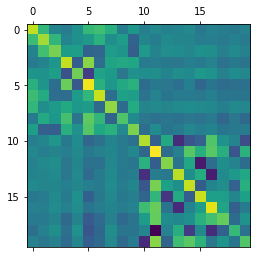

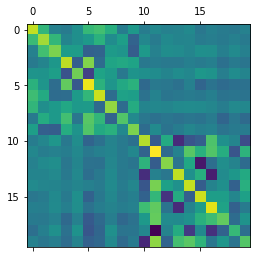

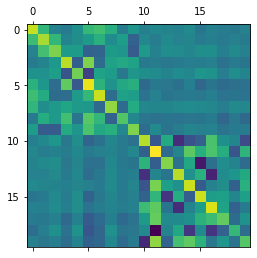

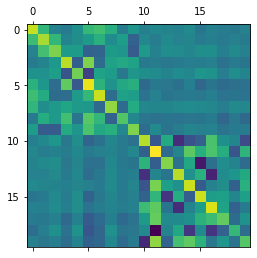

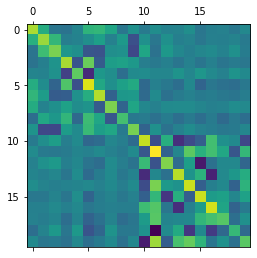

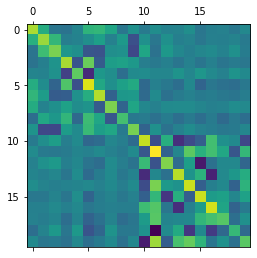

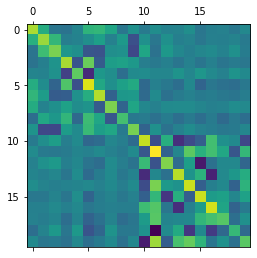

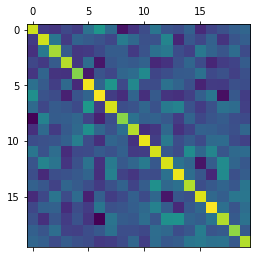

In [64]:

k=10
n = 100
x = x_test[k:k+n]
y = y_test[k:k+n]

print(y_test[k])

for i, layer in enumerate(model.layers[:-1]): 
    print(layer.name)
    
    aux_model1 = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
    aux_model2 = tf.keras.Model(inputs=model.layers[i+1].input, outputs=model.output)
    jac = [] 
    for i in range(n):

        with tf.GradientTape() as t:
            hidden = aux_model1(x[i:i+1])

            hidden = tf.Variable(hidden)
            logits = aux_model2(hidden) 
            probs = tf.concat((tf.nn.softmax(logits[:, :10]), tf.nn.softmax(logits[:, 10:])), axis=1)
#             print(f'loss: {cce_loss(y[i, 0], logits[:, :10])},  {cce_loss(y[i, 1], logits[:, 10:])}')
#             print(f'probs: {probs.shape}')
        j = t.jacobian(logits, hidden) 

        jac.append(j)

    
    jac = np.array(jac)

    jac = jac.reshape(n, 20, jac.size // (20*n))
#     jac = jac.reshape(20, jac.size // 20)

#     print(np.linalg.norm(jac, axis=1))
    M = np.einsum('mij,mkj->mik', jac / np.expand_dims(np.linalg.norm(jac, axis=2), axis=2), jac)
    M = M.mean(axis=0) 
    plt.matshow(M)
    print([M[i, i] for i in range(20)])


In [30]:
print(M)

[[ 2.30938315e-14  3.28689466e-21  3.18092167e-26  5.54051522e-22
   2.41092654e-21  3.70055857e-16  2.13263516e-13  3.76318711e-19
   2.17365213e-21  7.96694645e-21  1.71771177e-15 -1.82938785e-17
   9.01089980e-14  3.97562327e-13  4.06582267e-17 -3.23049869e-16
  -1.36427348e-16  9.54015773e-18 -5.23501815e-13 -2.02360562e-13]
 [ 3.28689466e-21  1.08448879e-18  4.21195380e-22  1.13383126e-24
   4.79908991e-23  1.37163265e-18 -3.08770244e-16  9.56990704e-23
   4.64494933e-22  1.20021943e-24  1.47700374e-13 -2.94616291e-15
  -1.49838705e-13  3.37188702e-16  3.53242131e-15  4.37416847e-17
  -7.94552705e-17  3.67440907e-17  3.03193580e-15 -1.50714933e-15]
 [ 3.18092167e-26  4.21195380e-22  1.17261365e-23 -1.32885004e-16
   8.19386293e-21  5.21022660e-22  4.39922761e-22  3.33272987e-21
   1.45075573e-24  1.78784292e-25  2.32736003e-15  6.20389389e-18
  -1.94333202e-15  1.89327870e-18 -7.15617357e-18 -4.31603301e-19
   1.04516597e-18  8.16102216e-17 -3.84108901e-16  4.97825748e-17]
 [ 5.54

In [ ]:
#PCA 

for j in range(5):
    my_dict = {}

    for layer in model.layers:
        if 'conv' in layer.name: 

            aux_model = tf.keras.Model(inputs=model.inputs,
                                       outputs=layer.output)

            # Access both the final and intermediate output of the original model
            # by calling `aux_model.predict()`.

            # we have 6 layers, some principle components, and n data points and n filters. 

            intermediate_layer_output = tf.reduce_mean(aux_model(x_test[:n]), axis=0)
            my_dict[layer.name] = []

    #         print(intermediate_layer_output.shape)

            for i in range(intermediate_layer_output.shape[-1]): 
                s, u, v = tf.linalg.svd(intermediate_layer_output[:, :, i])            
                my_dict[layer.name].append(s[j])



    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())

In [ ]:
n = 100

jac_dict = {}

"""
set up as:
{
  "layer_0": [[derivative vector for point 0 wrt L_d1], [derivative vector for point 0 wrt L_d2], 
  ..., [derivative vector for point n wrt L_d1], [derivative vector for point n wrt L_d2]],
.
.
.
{
  "layer_k": [[derivative vector for point 0 wrt L_d1], [derivative vector for point 0 wrt L_d2], 
  ..., [derivative vector for point n wrt L_d1], [derivative vector for point n wrt L_d2]]
} 
"""


def jacobian_f(weights, layer_name): 
    print(f'layer_name: {layer_name}')
#     print(f'weighst: {weights}')
    for i in tqdm(range(n)): 
        x = x_test[i:i+1]
        y = y_test[i:i+1]
        with tf.GradientTape() as t:
            logits = model(x) 
            cce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
            cce_loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

            loss1 = cce_loss(y[:, 0], logits[:, :10]) 
            loss2 = cce_loss2(y[:, 1], logits[:, 10:])
            loss = tf.convert_to_tensor([loss1, loss2])
        jac = t.jacobian(loss, weights)

        
#         print(jac[0].shape)
#         break
     
        jac_dict[name].append(jac[0])

#         if jac1 != None: 
#             print(jac1[0].shape)
#             print(tf.reshape(jac1[0], (-1, jac1[0].shape[-1])).shape)

for layer in model.layers: 
    name = layer.name 
    weights = layer.trainable_weights
    if weights != []:
        jac_dict[name] = []
        jacobian_f(weights, name)

In [ ]:

with open('jac_dict.pickle', 'wb') as handle:
    pickle.dump(jac_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print(a == b)

In [ ]:
m = n
plt.rcParams['figure.figsize'] = [12, 8]

for layer in model.layers: 
    name = layer.name 
    weights = layer.trainable_weights
    if weights != []:
        grads = jac_dict[name]
    #     print(len(grads))
    #     break
        X = np.array([g for g in grads])[:m] 
#         assert(X.shape[1] == 2)
        print(X.shape)
        X = X * weights[0].numpy()

        X = X.reshape(m, 2, -1)
        X = X.reshape(m*2, -1)

        Y = y_test[:m].numpy().reshape(-1).astype(np.int32)

        X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(X)

        labels = [i % 2 for i in range(2*m)]
        plt.figure()
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = labels)
        for i in range(0, len(X_embedded), 2):
            plt.plot(X_embedded[i:i+2, 0], X_embedded[i:i+2, 1], '-', lw=.4)
        for i in range(X_embedded.shape[0]):
            plt.text(X_embedded[i,0], X_embedded[i,1], str(Y[i]))
        plt.savefig(f'network1_{str(name)}')
        plt.show()


In [ ]:
#Average gradient for the output 
my_dict = {}
x_vals = []
y_vals = []

for i, layer in enumerate(model.layers): 
    name = layer.name 
    weights = layer.trainable_weights
    if weights != []:
        grads = jac_dict[name]
    #     print(len(grads))
    #     break
        X = np.array([g for g in grads])[:n] 
#         assert(X.shape[1] == 2)
        print(X.shape)
   
        if 'conv' in name: 
            X = X.mean(axis=(0,2,3,4))
          
        if 'dense' in name: 
            X = X.mean(axis=(0,3))
        
        print(f'{name} std: {np.std(X[0])},  {np.std(X[1])}')
#         my_dict[name] = (X[0] / np.std(X[0])) - (X[1] / np.std(X[1]))
        
        my_dict[name] = []

        for x in (X[0] / np.std(X[0])) - (X[1] / np.std(X[1])): 
            if x > .00001: 
                my_dict[name].append(x)
            
fig, ax = plt.subplots()

# ax.scatter(x_vals, y_vals)
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())

# fig2, ax2 = plt.subplots()
# ax2.boxplot(my_dict2.values())
# ax2.set_xticklabels(my_dict2.keys())

In [ ]:

print(X_h.shape)

In [ ]:
eps = .000000001
# eps = 0
plt.figure() 
layer_names = []
percent_connected_layer = []
for i, layer in enumerate(model.layers): 
    name = layer.name 
    print(f'\n---layer: {name}---\n')
    weights = layer.trainable_weights
    if weights != []:
        grads = jac_dict[name]
    #     print(len(grads))
    #     break
        X = np.array([g for g in grads])[:1] 
        
#         assert(X.shape[1] == 2)
        
        connected = ((-eps < X) & (X < eps)) == 0 
        #things that are not close to 0 are connected. negation of things close to 0
        print(connected.shape)
        connected_both = connected[:, 0] & connected[:, 1] #conected to both losses
        print(connected_both.shape)


        if 'conv' in name: 
            print(f'num_connected for each loss: {connected.sum(axis=(2, 3, 4, 5))}')
            print(f'num_disconnected for each loss: {(connected == 0).sum(axis=(2, 3, 4, 5))}')
            percent_connected = (connected).mean(axis=(2, 3, 4, 5))
            percent_connected_both = (connected_both).mean(axis=(1, 2, 3, 4))

        if 'dense' in name: 
            print(f'num_connected for each loss: {connected.sum(axis=(2, 3,))}')
            print(f'num_disconnected for each loss: {(connected == 0).sum(axis=(2, 3))}')
            percent_connected = (connected).mean(axis=(2, 3))
            percent_connected_both = (connected_both).mean(axis=(1, 2))

        
        print(f'percent_connected for each loss: {percent_connected}')
        print(f'percent_connected for both loss: {percent_connected_both}')

        print(percent_connected.shape)
        print(percent_connected_both.shape)
        temp = np.concatenate((percent_connected, percent_connected_both.reshape((1, 1))), axis=1)
        print(temp.shape)
        percent_connected_layer.append(temp)
        layer_names.append(name)

percent_connected_layer = np.array(percent_connected_layer).reshape(len(layer_names), 3)
print(percent_connected_layer.shape)
X_axis = np.arange(len(layer_names))
print(X_axis.shape)
plt.bar(X_axis - 0.2, percent_connected_layer[:,0], 0.2, label = 'L1')
plt.bar(X_axis + 0, percent_connected_layer[:,1], 0.2, label = 'L2')
plt.bar(X_axis + 0.2, percent_connected_layer[:,2], 0.2, label = 'Both')
 
plt.xticks(X_axis, layer_names)
plt.xlabel("Layer")
plt.ylabel("Percent of neurons connected")
# plt.title("Number of Students in each group")
plt.legend()
plt.savefig('specialization_by_layer.png')
plt.show()

In [ ]:

for layer in model.layers: 
    if 'conv' in layer.name: 
        filters, biases = layer.get_weights()
        # normalize filter values to 0-1 so we can visualize them

        print(filters.shape)
        # plot first few filters
        n_filters, ix = filters.shape[-1, 1
        
        R = 8 
        C = n_filters // R                               
        fig,axes = plt.subplots(R, C)

        for i in range(n_filters):
            # get the filter
            f = filters[:, :, 0, i]
            # plot each channel separately
                # specify subplot and turn of axis
            axes[i % 8, i // 8].set_xticks([])
            axes[i % 8, i // 8].set_yticks([])
            # plot filter channel in grayscale
            axes[i % 8, i // 8].matshow(f[:, :])
            axes[i % 8, i // 8].axis('off')
            ix += 1
        # show the figure
        plt.show()
